Interactive version of the tutorial: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pgrigorev/neighbors-maps.git/HEAD?labpath=tutorials%2Fdefect_detection.ipynb)

In [10]:
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
output_notebook()


import sys
sys.path.insert(0, "../")
from neighbor_map import Atoms
from ase.atoms import Atom


def get_cutoff(atoms, n_neightbours, cutoff=10.):
    """
    Function to get the distance of n_th neighbour using matscipy neighbour list.
    """
    from matscipy.neighbours import neighbour_list

    i, d = neighbour_list("id", atoms, cutoff=cutoff)
    first_atom_d = d[i == 0]
    first_atom_d.sort()
    return first_atom_d[n_neightbours]

Loading BokehJS ...

We will look at four examples of cubic structures:
- Simple Cubic (SC): Po 
- Bulk Centered Cubic (BCC): Fe
- Face Centered Cubic (FCC): Ni
- Diamond: C

[Atomic Simulations Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) has an excellent set of tools for [building things](https://wiki.fysik.dtu.dk/ase/ase/build/build.html). We just need to provide the symbol of the element and it will create a unit cell with the structure and lattice parameter from the internal database. 

In [2]:
from ase.build import bulk

unit_cells = []
for symbol in ["Po", "Fe", "Ni", "C"]:
    unit_cells.append(bulk(symbol, cubic=True))
    

Lets have a look on the structures. We will use [nglview](https://github.com/nglviewer/nglview) for interactive visulisations.

In [3]:
def show_structures(structures, labels):
    from nglview import show_ase, ASEStructure

    # create an empty canvas
    view = show_ase(structures[0], default_representation=False)
    view.remove_component(view[0])

    for label, structure in zip(labels, structures):
        # add new component to visualise
        component  = view.add_component(ASEStructure(structure), default_representation=False, name=label + " " + str(structure.symbols))
        
        # set up the vew as just atomic spheres with unit cell
        scale=0.5
        component.add_spacefill()
        component.update_spacefill(radiusType='covalent',
                                radiusScale=scale)
        component.add_unitcell()

        # show only simple cubic in starting window
        if label != "Simple Cubic":
            component.hide()

    view.camera = 'orthographic'
    view.parameters = {"clipDist": 0}

    view.gui_style = "NGL"
    return view

In [4]:
labels = ["Simple Cubic", "BCC", "FCC", "Diamond"]
show_structures(unit_cells, labels=labels)

ThemeManager()

NGLWidget(gui_style='ngl')

Lets look on the larger cells that we will use as a mode of bulk structures. To create on we just need to replicate the unit cell N times in each directions. We will use the cells of size 4x4x4 in this tutorial.

In [5]:
bulks = []
vacancies = []
interstitials = []

for unit_cell in unit_cells:
    bulk = unit_cell * [4, 4, 4]
    bulks.append(Atoms(bulk))
    
    vacancy = bulk.copy()
    del vacancy[1]
    vacancies.append(Atoms(vacancy))

    interstitial = bulk.copy()
    interstitial.extend(Atom(symbol, (2.5, 2.5, 1.5)))
    interstitials.append(Atoms(interstitial))

In [6]:
show_structures(bulks, labels=labels)

NGLWidget(gui_style='ngl')

In [149]:
Fe = bulks[1]

interactive_neighbour_map(Fe, target_img_size=8, cutoff_factor=1.0)

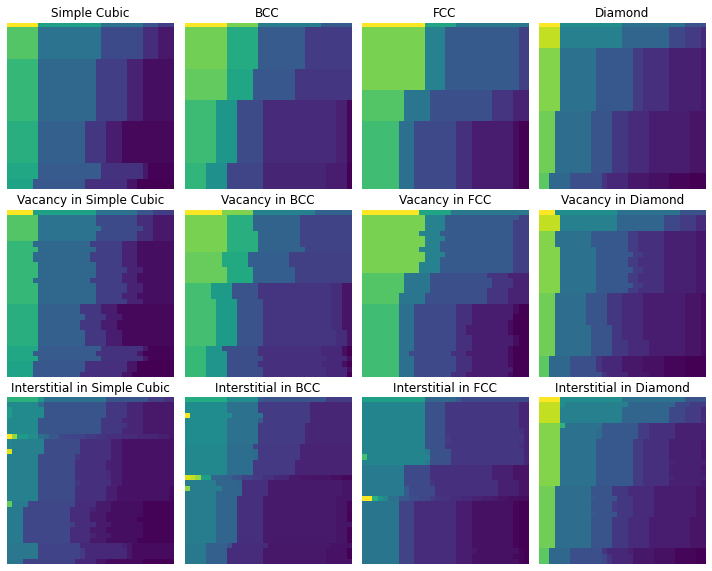

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))

for structure, title, ax in zip(bulks, labels, axes[0]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title(title)
    ax.axis("off")

for structure, title, ax in zip(vacancies, labels, axes[1]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Vacancy in " + title)
    ax.axis("off")


for structure, title, ax in zip(interstitials, labels, axes[2]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Interstitial in " + title)
    ax.axis("off")

    
fig.tight_layout()

The preliminary outline of the tutorial:
- Introduction to neighbour maps as above (maybe more details about how it is constructed). Maybe add 3D interactive NGlView visualisations of atomic configurations?
- Training of the classifier on the on defects identified by Distortion Scores. Data should be provided in `data` folder. (Ask Sacha)
- Application to the MD data of the cascade. Ideally I should provide a MD simulation where C15 cluster is formed. Perhaps will need few cascades one after another. We should think how we then use the mapping: just a nice movie or extraction of physical data such as temperature of molten region etc.?

Do you think interactive plots could be helpful?

In [143]:
import numpy as np
import pandas as pd
import networkx as nx

from matscipy.neighbours import neighbour_list

from bokeh.plotting import figure, from_networkx, show, save, output_file
from bokeh.palettes import Spectral4
from bokeh.models import Circle, NodesAndLinkedEdges, MultiLine, LinearColorMapper, CustomJS, HoverTool, TapTool
from bokeh.palettes import Viridis256
from bokeh.layouts import row

def interactive_neighbour_map(structure, 
                              target_atom_index = 0,
                              target_img_size=32,
                              cutoff_factor=1.2):

    i, j, d = neighbour_list("ijd", structure, cutoff=cutoff_factor * get_cutoff(Fe, target_img_size))

    sorting = np.argsort(d[i==target_atom_index])

    neighbour_indices = j[i==target_atom_index][sorting]
    img_size = min(len(neighbour_indices), target_img_size)
    
    source = i[i==target_atom_index][:img_size]

    target = neighbour_indices[:img_size]
    distance = d[i==target_atom_index][sorting][:img_size]

    sphere_indices = np.append(neighbour_indices, target_atom_index)

    for neighbour_index in neighbour_indices[:img_size - 1]:

        distances = structure.get_distances(neighbour_index, sphere_indices, mic=True)
        sorting = np.argsort(distances)
        # first element will be zero since this is the distance from the atom itself
        # thus we simply ignore the first record
        target = np.append(target, sphere_indices[sorting][1:img_size + 1])
        distance = np.append(distance, distances[sorting][1:img_size + 1])

        source = np.append(source, np.full(img_size, neighbour_index))

    weights = 1 / (distance).reshape((img_size, img_size))
    
    pd_edges = pd.DataFrame({"source": source,
                             "target": target,
                             "distance": distance,
                             "weight": weights.flatten()})
                         
    G = nx.from_pandas_edgelist(pd_edges, edge_attr=True)


    mapper = LinearColorMapper(palette=Viridis256)

    p = figure(x_range=(-2, 2), y_range=(-2, 2),
            x_axis_location=None, y_axis_location=None,
            tools="hover, tap", tooltips="index: @index")

    p.grid.grid_line_color = None

    graph = from_networkx(G, nx.spring_layout, scale=1.8, center=(0,0))

    p.renderers.append(graph)

    graph.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
    #graph.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
    graph.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

    graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
    graph.edge_renderer.selection_glyph = MultiLine(line_color={'field': 'weight', 'transform': mapper}, line_width=5)
    graph.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

    graph.selection_policy = NodesAndLinkedEdges()
    graph.inspection_policy = NodesAndLinkedEdges()

    # application of the attention factor for the image rows with 1/r^beta
    A = np.concatenate(([1], distance[:img_size - 1])) ** (-1./6.)
    image_weights = A.reshape((-1, 1)) / distance.reshape((img_size, img_size))

    image_weights = np.pad(image_weights, ((0, target_img_size - img_size), (0, target_img_size - img_size)))
    
    target = target.reshape(img_size, img_size)
    target = np.pad(target, ((0, target_img_size - img_size), (0, target_img_size - img_size)), constant_values=-1)
    
    distance = distance.reshape(img_size, img_size)
    distance = np.pad(distance, ((0, target_img_size - img_size), (0, target_img_size - img_size)))   
    

    data = {"weights": [np.array([image_weights[i,:]]) for i in range(target_img_size)],
            "target": [np.array([target[i,:]]) for i in range(target_img_size)],
            "distance": [np.array([distance[i,:]]) for i in range(target_img_size)],
            "x": np.zeros(target_img_size),
            "y": np.arange(target_img_size)[::-1],
            "dw": np.full(target_img_size, target_img_size),
            "dh": np.full(target_img_size, 1),
            "index": np.pad(source[::img_size], (0, target_img_size - img_size), constant_values=-1)}

    TOOLTIPS = [('index', "@index"),
                ('target', '@target'),
                ("weight", "@weights"),
                ('distance', '@distance')]

    img = figure(tools=())
    color_mapper = LinearColorMapper(palette="Viridis256", low=image_weights.min(), high=image_weights.max())

    img.image(source=data, image="weights", color_mapper=color_mapper)
    xx, yy = np.meshgrid(np.arange(target_img_size), np.arange(target_img_size))

    size = 0.825 * img.height / (target_img_size)

    img.square(xx.flatten() + 0.5, yy.flatten() + 0.5, size=size, line_width=2.,
              fill_color="grey", line_color = "firebrick", hover_line_alpha=1.0, alpha=0.0)


    img.add_tools(TapTool(renderers=[img.renderers[0]]))
    img.add_tools(HoverTool(renderers=[img.renderers[0]], tooltips=TOOLTIPS))
    img.add_tools(HoverTool(renderers=[img.renderers[1]], tooltips=None))

    nodes = graph.node_renderer.data_source
    image_source = img.renderers[0].data_source

    nodes_tap_handler = CustomJS(args=dict(nodes=nodes, image_source=image_source), code='''
                                const inds = nodes.selected.indices
                                console.log('Selection node at: ' + inds)
                                image_source.selected.indices = inds
                                ''')

    nodes.selected.js_on_change("indices", nodes_tap_handler)

    image_tap_handler = CustomJS(args=dict(nodes=nodes, image_source=image_source), code='''
                                const inds = image_source.selected.indices
                                console.log('Selection image at: ' + inds)
                                nodes.selected.indices = inds
                                ''')

    image_source.selected.js_on_change("indices", image_tap_handler)
    layout = row(p, img)

    show(layout)